In [ ]:
!pip install mvlearn==0.5.0 wordcloud==1.9.3 matplotlib==3.3.4 distinctipy==1.3.4 networkx==3.2.1  umap==0.1.1 hoggorm==0.13.3 adilsm==0.0.7 scipy==1.9.1
# scipy==1.12.0 not used (due to changes in SVDS) to reproduce presented results in ref paper

In [1]:
from adnmtf import NMF, NTF
import pandas as pd
import numpy as np
from IPython.display import clear_output
import time
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import matplotlib.image as image
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import distinctipy
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

import sys
import networkx as nx

from sklearn.preprocessing import normalize
from sklearn import metrics

from mvlearn.datasets import load_UCImultifeature
from mvlearn.embed import MVMDS
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
import umap
from scipy.spatial import distance_matrix
import hoggorm as ho
import adilsm.adilsm as ilsm

Data prep

In [2]:
###############################################################################
# Load Data
# ---------
# Data comes from UCI Digits Data. Contains 6 views and classifications of
# numbers 0-9

Xs, list_digits = load_UCImultifeature()

sample_rate = 1

if sample_rate < 1:
    num_rows = list_digits.shape[0]
    num_rows_to_select = int(num_rows * sample_rate)
    selected_rows = np.random.choice(num_rows, num_rows_to_select, replace=False)

    for i in range(len(Xs)):
        Xs[i] = Xs[i][selected_rows]

    list_digits = list_digits[selected_rows]

list_cell_codes, list_cell_types = pd.factorize(list_digits)

# Check data
print(f'There are {len(Xs)} views.')
print(f'There are {Xs[0].shape[0]} observations')
print(f'The feature sizes are: {[X.shape[1] for X in Xs]}')


There are 6 views.
There are 2000 observations
The feature sizes are: [76, 216, 64, 240, 47, 6]


In [3]:
X_car_p = Xs[2].copy()
X_car_p[X_car_p<0] = 0
X_car_n = -Xs[2].copy()
X_car_n[X_car_n<0] = 0

Xs_concat = Xs[0]
Xs_concat = np.hstack((Xs_concat, Xs[1], X_car_p, X_car_n))

# Xs_concat = np.hstack((Xs[0], Xs[1]))


for X in Xs[3:]:
    Xs_concat = np.hstack((Xs_concat, X))

m0 = Xs_concat

# m0_nan_0 = m0.copy()

# # create m0_weight with ones and zeros if not_missing/missing value
# m0_weight = np.where(np.isnan(m0), 0, 1)
# m0_nan_0[np.isnan(m0_nan_0)]=0

# max_values = np.max(m0_nan_0, axis=0)
# # Replace maximum values equal to 0 with 1
# m0 = np.divide(m0, np.where(max_values == 0, 1, max_values))

# df_m0 = pd.DataFrame(m0)
# df_m0.to_csv(RESULTS_PATH + r'\m0.csv', sep=',', na_rep='.', index=True)


list_columns = [str(i) for i in range(m0.shape[1])]
score_pref = ['mfeat-fou', 'mfeat-fac', 'mfeat-kar-p', 'mfeat-kar-n', 'mfeat-pix', 'mfeat-zer', 'mfeat-mor']
n_items = [Xs[i].shape[1] for i in range(2)] + [X_car_p.shape[1], X_car_n.shape[1]] + [Xs[i].shape[1] for i in range(3, len(Xs))]
# score_pref = ['mfeat-fou', 'mfeat-fac', 'mfeat-pix', 'mfeat-zer', 'mfeat-mor']
# n_items = [Xs[i].shape[1] for i in range(2)] + [Xs[i].shape[1] for i in range(3, len(Xs))]
n_scores = len(n_items)

ISM workflow

In [4]:
n_embedding, n_themes = [9,10]

h4_updated, h4_updated_sparse, w4_ism, h4_ism, q4_ism, tensor_score, m0_norm = ilsm.ism(m0, n_embedding, n_themes, n_scores, n_items, norm_m0=True, update_h4_ism=True,
                                                                        max_iter_mult=200, fast_mult_rules=True, sparsity_coeff=.8)
print('condition number('+str(n_embedding)+', '+str(n_themes)+') = ', np.round(np.linalg.cond(h4_updated_sparse), 2))
error = np.linalg.norm(m0_norm -  w4_ism @ h4_updated_sparse.T) / np.linalg.norm(m0_norm)
print('error: ',round(error, 2))

condition number(9, 10) =  7.65
error:  0.52


Figures

In [5]:
# 16-16 with .8
# generate N visually distinct colours

# MDS projection
mds = MDS(n_components=2, random_state=0)
# mds = umap.UMAP(random_state=0, n_jobs=1, min_dist=1)

n_marker_genes = list_cell_codes.shape[0]

stress = []

w4_ism_mds = mds.fit_transform(normalize(w4_ism[:n_marker_genes,:], axis=0, norm='l2'))
stress.append(mds.stress_)

print(stress)

[491.4730131240673]


10 5.81


<function matplotlib.pyplot.show(close=None, block=None)>

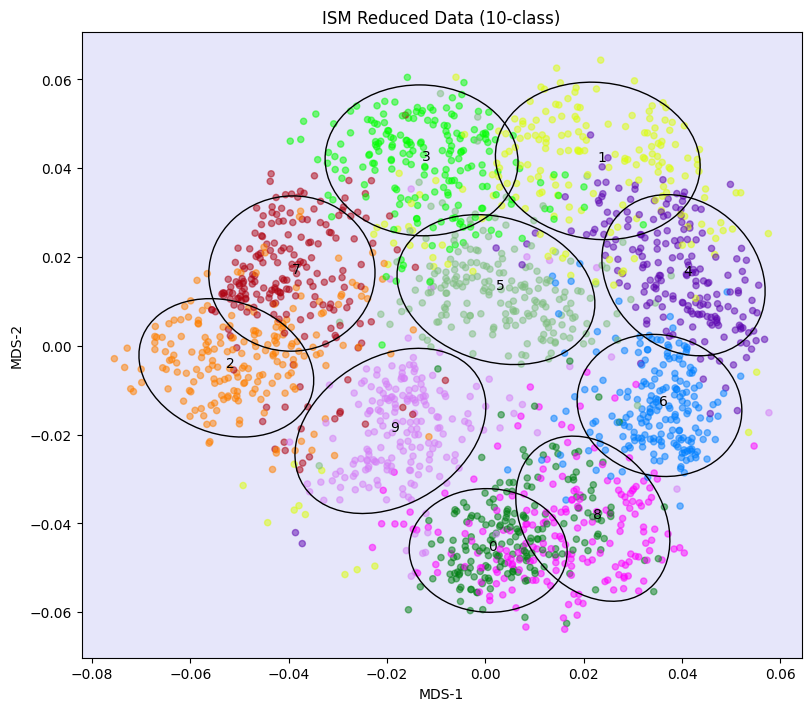

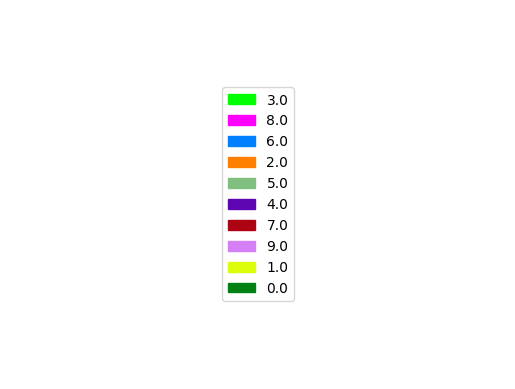

In [6]:
palette = distinctipy.get_colors(10)
cmap = ListedColormap(palette)

patches = []
for code in range(10):
    patches.append(mpatches.Patch(color=palette[code], label=list_cell_types[code]))

# Define a function to plot the confidence ellipse
def confidence_ellipse(x, y, cell_label, ax, n_std=2, facecolor='none', **kwargs):
    # Create a plot of the covariance confidence ellipse of `x` and `y`
    # Adapted from [1](https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html)
    
    # Calculate the covariance matrix and the Pearson correlation coefficient
    cov = np.cov(x, y)
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    
    # Use a special case to obtain the eigenvalues of the covariance matrix
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    
    # Create the ellipse object
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)
    
    # Scale and translate the ellipse according to the mean and standard deviation of the data
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)
    ellipse.set_transform(transf + ax.transData)
    
    # Annotate centroid
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    ax.annotate(int(cell_label), xy=(x_mean, y_mean))

    # Add the ellipse to the axes
    ax.add_patch(ellipse)
    return x_mean, y_mean

# define a function to plot scatter with clusters and confidence ellipses
def plot_scatter(x, y, title=None, k=None, ax=None, list_cell_codes=None, skip_ellipse=[], face_color='lavender', **kwargs):
    # Perform k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(np.c_[x, y])
    # Get the cluster labels and centroids
    labels = kmeans.labels_  # Get cluster labels
    labels_matched = np.empty_like(labels)
    unique_labels = np.unique(labels)
    truth_label = np.zeros(len(unique_labels))

    # For each cluster label...
    for l in unique_labels:
        # ...find and assign the best-matching truth label
        match_nums = [np.sum((labels==l)*(list_cell_codes==t)) for t in np.unique(list_cell_codes)]
        truth_label[l] = np.unique(list_cell_codes)[np.argmax(match_nums)]
        labels_matched[labels==l] = truth_label[l]

    ax.scatter(x, y, c=list_cell_codes[:n_marker_genes], cmap=cmap, alpha=0.5, s=20)
    ax.set_title(title)
    ax.set_xlabel("MDS-1")
    ax.set_ylabel("MDS-2")
    ax.set_facecolor(face_color)

    p1 = np.zeros(k)
    p2 = np.zeros(k)
    unique_labels_matched = np.unique(labels_matched)
    xy_mean = np.zeros((len(unique_labels),2))    
    mean_intra_distance = np.zeros(len(unique_labels))
    mean_inter_distance = np.zeros(len(unique_labels))
    flag = np.zeros(len(unique_labels))

    for l in unique_labels_matched:
        indices = np.where(truth_label == l)[0]
        if indices.shape[0] > 1:
            # calculate mean distance inter-clusters pointing to same class
            xy_mean2 = np.zeros((indices.shape[0],2))
            for l2 in range(len(indices)):
                xy_mean2[l2,0] = np.mean(x[labels == indices[l2]])
                xy_mean2[l2,1] = np.mean(y[labels == indices[l2]])
                xy_intra = np.column_stack((x[labels == indices[l2]], y[labels == indices[l2]]))
                D = distance_matrix(xy_intra, xy_intra)
                mean_intra_distance[l] += np.mean(D[D>0])
                    
            D = distance_matrix(xy_mean2, xy_mean2)
            mean_inter_distance[l] = np.mean(D[D>0])
            if mean_inter_distance[l] / mean_intra_distance[l] > 1:
                flag[l] = 1

    n_matched_cell_types = 0
    
    for l in np.unique(labels_matched):
        if l not in skip_ellipse:
            p1[l] = np.sum(labels_matched[labels_matched==l] == list_cell_codes[labels_matched==l])
            p2[l] = p1[l] / np.sum(list_cell_codes == l)
            p1[l] /=  np.sum(labels_matched == l)
            if p2[l] > .5:
                n_matched_cell_types += 1
                xy_mean[l,0], xy_mean[l,1] = confidence_ellipse(x[labels_matched == l], y[labels_matched == l], list_cell_types[l], ax, n_std=2, edgecolor='black')
            else:
                p1[l] = 0
                p2[l] = 0
        else:
            xy_mean[l,0] = 0
            xy_mean[l,1] = 0
    
    inter_distance = distance_matrix(xy_mean, xy_mean)
    mean_inter_distance = np.mean(inter_distance[inter_distance>0])
    norm_distance = np.max(inter_distance) - inter_distance
    # print(p1)
    # print(p2)
    print(n_matched_cell_types, round(np.sum(p1*p2),2))

# fig, ax = plt.subplots(3, 2, figsize=(14, 18), constrained_layout=True)
fig, ax = plt.subplots(figsize=(8, 7), constrained_layout=True)

face_color = 'lavender'
k=10

plot_scatter(w4_ism_mds[:, 0], w4_ism_mds[:, 1], title="ISM Reduced Data (10-class)", k=k, ax=ax, list_cell_codes=list_cell_codes, skip_ellipse=[])

plt.show

# Add the legend to a new figure
fig2, ax2 = plt.subplots()
ax2.legend(handles=patches, loc='center')
plt.gca().set_axis_off()
ax2.set_facecolor(face_color)
plt.show